# Creating the network

Creating the network .gml file from the column given

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import ast
import json

In [19]:
df = pd.read_csv("../data/postings_parsed.csv")
df['skills'] = df['skills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df.head()

,job_id,company_name,description,skills_desc,zip_code,skills
0,921716,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,8540.0,[planning]
1,1829192,NaN,"At Aspen Therapy and Wellness , we are committ...",NaN,80521.0,"[planning, communication, interpersonal]"
2,10998357,The National Exemplar,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,45202.0,"[organization, teamwork, communication]"
3,23221523,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,11040.0,"[problem-solving, planning, communication, pla..."
4,35982263,NaN,Looking for HVAC service tech with experience ...,NaN,52601.0,[]


In [20]:
# Creating a network graph
G = nx.Graph()

# Iterate over each list of skills in the dataframe
for skill_list in df['skills']:
    skill_list = list(skill_list)
    # Add nodes and edges for every combination of skills in the list
    for skill1, skill2 in combinations(skill_list, 2):
        if G.has_edge(skill1, skill2):
            # Increment weight if edge already exists
            G[skill1][skill2]['weight'] += 1
        else:
            # Add edge with initial weight
            G.add_edge(skill1, skill2, weight=1)

# Export the graph to a GML file
nx.write_gml(G, '../graphs/skills_graph.gml')

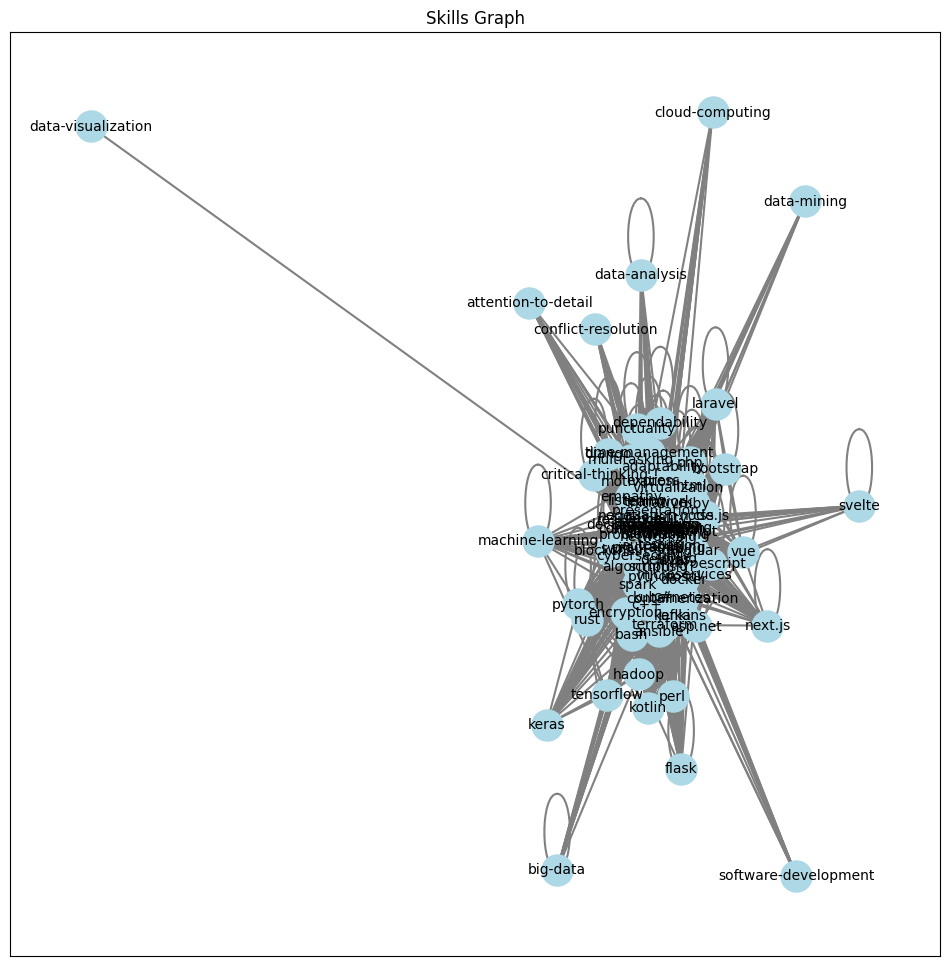

In [21]:
# Read the GML File and plot the graph
plt.figure(figsize=(12, 12))  # Set the figure size

# Draw the graph with a spring layout (which tries to position nodes in a visually pleasing way)
pos = nx.spring_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.5, edge_color='gray')

# Draw the labels for each node
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Display the plot
plt.title("Skills Graph")
plt.show()

# Average Degree

In [22]:
# Printing the useful information of the graphs
G = G.to_undirected()

# Average degree
degrees = []
for node, deg in G.degree():
    degrees.append(deg)
average_degree = sum(degrees) / len(degrees)
print(f"Average degree of the graph: {average_degree}")

Average degree of the graph: 64.08510638297872


# Clustering Coefficient
### Average clustering coefficient
<What does the average clustering coefficient represent? >

### Global clustering coefficient
<What does the average clustering coefficient represent? >

In [23]:
# 1. Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering}")

# 2. Global clustering coefficient (Transitivity)
global_clustering = nx.transitivity(G)
print(f"Global Clustering Coefficient (Transitivity): {global_clustering}")

Average Clustering Coefficient: 0.8578052331848044
Global Clustering Coefficient (Transitivity): 0.818226200162734


# Nodes with highest degree

In [24]:
# Getting the most connected nodes

nodes_with_degrees = G.degree()

sorted_nodes = sorted(nodes_with_degrees, key=lambda x: x[1], reverse=True)

# Get the top 10 nodes with the highest degree
top_10_nodes = sorted_nodes[:10]

# Print the result
for node, degree in top_10_nodes:
    print(f"Node: {node}, Degree: {degree}")

Node: communication, Degree: 94
Node: problem-solving, Degree: 92
Node: leadership, Degree: 92
Node: organization, Degree: 91
Node: writing, Degree: 91
Node: innovation, Degree: 91
Node: testing, Degree: 91
Node: sql, Degree: 91
Node: collaboration, Degree: 90
Node: agile, Degree: 90


# Plotting the graphs

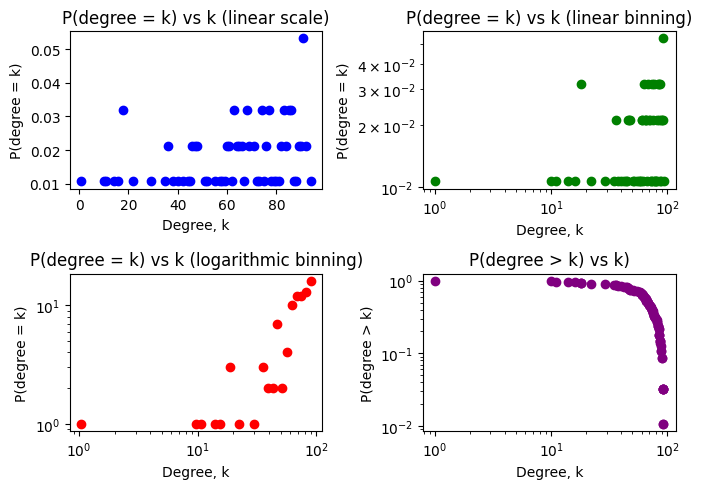

In [25]:
k_values, P_k = np.unique(degrees, return_counts=True)
P_k = P_k / sum(P_k)

# Creating subplot for the four different plots
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

# === 1. P(degree = k) as a function of k in linear scale ===
# This is equivalent to just plotting the graphs
axs[0, 0].scatter(k_values, P_k, color='blue')
axs[0, 0].set_xlabel('Degree, k')
axs[0, 0].set_ylabel('P(degree = k)')
axs[0, 0].set_title('P(degree = k) vs k (linear scale)')

# === 2. P(degree = k) in a log-log scale with linear binning
axs[0, 1].scatter(k_values, P_k, color='green')
# Allows me to log the x and the y graphs
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Degree, k')
axs[0, 1].set_ylabel('P(degree = k)')
axs[0, 1].set_title('P(degree = k) vs k (linear binning)')

# === 3. P(degree = k) in a log-log scale with log binning (x-axis)

# Creating bins on a logarithmic scale.
# This means that the width of the spaces increases
k_bins = np.logspace(np.log10(min(k_values)), np.log10(max(k_values)))
# hist: Counts the degrees within each bin
# bin_edges: Boundaries of each bin, so we only want to plot the middle point
hist, bin_edges = np.histogram(degrees, bins=k_bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

axs[1, 0].scatter(bin_centers, hist, color='red')
# Allows me to log the x and the y graphs
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Degree, k')
axs[1, 0].set_ylabel('P(degree = k)')
axs[1, 0].set_title('P(degree = k) vs k (logarithmic binning)')

# === 4. P(degree = k) in a log-log scale with log binning (x-axis)
# Sort degrees in descending order
sorted_degrees = np.sort(degrees)[::-1]
# Calculate the CCDF: P(degree > k) for each degree
# np.sum(sorted_degrees > k) is the CCDF.
ccdf = np.array([np.sum(sorted_degrees > k)
                for k in sorted_degrees]) / len(degrees)

# Plot the CCDF
axs[1, 1].scatter(sorted_degrees, ccdf, color='purple')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Degree, k')
axs[1, 1].set_ylabel('P(degree > k)')
axs[1, 1].set_title('P(degree > k) vs k)')

plt.tight_layout()
plt.show()
